## Multiple Linear Regression To Predict Quantitative Meausure Of Disease Progession

Notebook by Anthony Rodriguez

## Introduction

This notebook uses multiple linear regression to predict a qunatitative measure of diabetes. The data is taken from a [toy dataset provided by scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes). Linear regression  is first implemented using Python and basic Numpy operations. Then linear regression is implemented again more optimally by taking advantage of Numpy's matrix multiplication. Then we compare our results with scikit-learn's SGDRegressor.

**The EDA on this dataset can be seen in this [notebook](../../ExploratoryDataAnalysis/DiabetesDataset.ipynb).** You can open up that notebook to get a good look at the data.

In [1]:
from sklearn.datasets import load_diabetes

import math
import numpy as np

In [2]:
X_data, y_data = load_diabetes(return_X_y=True)

## Training a Univariate Linear Regression Model

#### This data will allow us to use a mulitple linear function $f$ of a vector $\mathbf{x}$, containing multiple variables. That is, $f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b$. 

$\mathbf{w}$, a vector, and $b$, a scalar, are parameters we must find.

#### We can do this by minimizing the cost $J(\mathbf{w},b) = \frac{1}{2m}\sum\limits^{m-1}_{i=0}(f_{w,b}(\mathbf{x}^{(i)}) - y^{(i)})^{2}$
#### where $f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b$ is the estimated cost of training example $\mathbf{x}^{(i)}$.

#### $y^{(i)}$ is the true cost of training example $\mathbf{x}^{(i)}$.

#### In order to find $\mathbf{w}$ and $b$ by minimizing the cost $J(\mathbf{w},b)$, we must use it's gradient

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial \mathbf{w}}  &= \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})\mathbf{x}^{(i)} \newline
  \frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})
\end{align}
$$

#### We then repeat until convergence

$$\begin{align*} \newline
\;  \mathbf{w} &= \mathbf{w} -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial \mathbf{w}} \newline 
 b &= b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline
\end{align*}$$

#### where, parameters $\mathbf{w}$, $b$ are updated simultaneously.

Let's create a class that implements Linear Regression architecture and uses the Gradient Descent algorithm to build a model.

In [3]:
class LinearRegressionGD:
    """
    The linear regression model that runs the gradient descent algorithm.
    """
    def __init__(self, alpha=1.0, max_iters=1000):
        """
        Creates Linear_Regression object.
        
        Parameters
        -----------
        self (LinearRegressionGD): A LinearRegressionGD object.
        alpha (float): The learning rate.
        max_iters (int): The maximum number of iterations of the gradient descent algorithm.
        """
        self.__alpha = alpha
        self.__max_iters = max_iters
        self.__w = None
        self.__b = None
        self.__J_history = [] # Stores the cost J of each iteration in gradient descent.
        self.__p_history = [] # Stores the history of parameters of each iteration in gradient descent.
        
    def get_parameters(self):
        '''
        self (LinearRegressionGD): A LinearRegressionGD object.
        
        Returns
        --------
        (ndarray(n,), ndarray(1,)) : The model parameters, weights and bias.
        '''
        return self.__w, self.__b
    
    def get_cost_history(self):
        '''
        self (LinearRegressionGD): A LinearRegressionGD object.
        
        Returns
        --------
        (list) : The history of cost when training the model.
        '''
        return self.__J_history
        
    def train(self, X_train, y_train, print_iterations=False):
        '''
        Trains the linear regression model using the gradient descent algorithm.
        
        Parameters
        ----------
        self (LinearRegressionGD): A LinearRegressionGD object.
        X_train (ndarray (m, n)): The training examples.
        y_train (ndarray(m,)): The training targets.
        print_iterations (bool): True if wanting information to be printed on every iteration, false otherwise.
        '''        
        self.__compute_gradient_function = self.__compute_gradient
        self.__cost_function = self.compute_cost
        self.__train(X_train, y_train, print_iterations)
        
    def train_optimized(self, X_train, y_train, print_iterations=False):
        '''
        Trains the linear regression model in a more optimally fashion using Numpy's
        matrix multiplication in the gradient descent algorithm.
        
        Parameters
        -----------
        self (LinearRegressionGd): A LinearRegressionGD object.
        X_train (ndarray (m, n)): The training examples.
        y_train (ndarray(m,)): The training targets.
        print_iterations (bool): True if wanting information to be printed on every iteration, false otherwise.
        '''        
        self.__compute_gradient_function = self.__compute_gradient_optimized
        self.__cost_function = self.compute_cost_optimized
        self.__train(X_train, y_train, print_iterations)
        
    def compute_cost(self, X, y):
        '''
        Computes the cost of the model.
                
        Parameters
        -----------
        self (LinearRegressionGd): A LinearRegressionGD object.
        X (ndarray (m, n)): The training examples.
        y (ndarray(m,)): The training targets.
        
        Returns
        --------
        (float): the cost of the model.
        '''
        cost = self.compute_mse(X, y) / 2
        return cost[0]
    
    def compute_mse(self, X, y):
        '''
        Computes the mean squared error.
                
        Parameters
        -----------
        self (LinearRegressionGd): A LinearRegressionGD object.
        X (ndarray (m, n)): The training examples.
        y (ndarray(m,)): The training targets.
        
        Returns
        --------
        (float): the mean sqaured error.
        '''
        m = X.shape[0]
        i = 0
        total_loss = 0

        while i < m:
            loss_i = self.__compute_loss(X, y, i)
            total_loss = total_loss + (loss_i**2)
            i += 1

        return total_loss / m

    def compute_cost_optimized(self, X, y):
        '''
        Computes the cost of the model optimally using matrix multiplication.
                
        Parameters
        -----------
        self (LinearRegressionGd): A LinearRegressionGD object.
        X (ndarray (m, n)): The training examples.
        y (ndarray(m,)): The training targets.
        
        Returns
        --------
        (float): the cost of the model.
        '''
        return self.compute_mse_optimized(X, y) / 2
    
    def compute_mse_optimized(self, X, y):
        '''
        Computes the mean squared error optimally using matrix multiplication.
                
        Parameters
        -----------
        self (LinearRegressionGd): A LinearRegressionGD object.
        X (ndarray (m, n)): The training examples.
        y (ndarray(m,)): The training targets.
        
        Returns
        --------
        (float): the mean sqaured error.
        '''
        m,n = X.shape
        error = self.__compute_loss_optimized(X, y)
        squared_error = error**2
        return np.sum(squared_error / m)
        
    def predict(self, X):
        '''
        Predicts the numerical value using X, model weights and bias.
        
        Parameters
        -----------
        self (LinearRegressionGd): A LinearRegressionGD object.
        X (ndarray (m, n)): The data to use for predictions.
        
        Returns
        --------
        (ndarray(m,)): The predictions.
        '''
        return X @ self.__w + self.__b
        
    def __train(self, X_train, y_train, print_iterations=False):
        '''
        Trains the linear regression model using gradient descent.
        
        Parameters
        -----------
        self (LinearRegressionGd): A LinearRegressionGD object.
        X_train (ndarray (m, n)): The training examples.
        y_train (ndarray(m,)): The training targets.
        print_iterations (bool): True if wanting information to be printed on every iteration, false otherwise.
        '''
        self.__w = np.zeros_like(X_train[0])
        self.__b = np.array([0])
        
        # An array to store cost J and w's at each iteration primarily for graphing later
        self.__J_history = []
        self.__p_history = []
        
        self.__gradient_descent(X_train, y_train, print_iterations)
        
    def __gradient_descent(self, X_train, y_train, print_iterations):
        '''
        Runs the gradient descent algorithm.
        
        Parameters
        ----------
        self (LinearRegressionGd): A LinearRegressionGD object.
        X_train (ndarray (m, n)): The training examples.
        y_train (ndarray(m,)): The training targets.
        print_iterations (bool): True if wanting information to be printed on every iteration, false otherwise.
        '''
        if print_iterations:
            self.__print_header()
            
        for i in range(self.__max_iters):
            # Calculate the gradient and update the parameters using gradient_function
            dj_dw, dj_db = self.__compute_gradient_function(X_train, y_train)
            
            # Record old parameters
            last_b, last_w = self.__b, self.__w

            # Update Parameters
            self.__b = self.__b - self.__alpha * dj_db                            
            self.__w = self.__w - self.__alpha * dj_dw
            
            # Check if new parameters are equal to the last iterations parameters
            if self.__is_convergence(last_w, last_b):                
                if print_iterations:                    
                    print('Convergence')
                    info = f'{i}\t    {J_history[-1][0]:.2}\t'

                    for w_i in w:
                        info += f'{w_i:.1e}  '

                    info += f'{b:.2e}  '

                    for dj_dw_i in dj_dw:
                        info += f' {dj_dw_i:.1e}  '

                    info += f'{dj_db}'
                    print(info)
                
                break
                
            # Save cost J at each iteration
            self.__J_history.append(self.__cost_function(X_train, y_train))
            self.__p_history.append([self.__w, self.__b])
                
            # Print cost every at intervals 10 times or as many iterations if max iters < 10
            if print_iterations and i% math.ceil(self.__max_iters/10) == 0:
                info = f'{i}\t    {self.__J_history[-1][0]:.2}\t'
                
                for w_i in self.__w:
                    info += f'{w_i:.1e}  '
                    
                info += f'{self.__b[0]:.2e}  '
                    
                for dj_dw_i in dj_dw:
                    info += f' {dj_dw_i:.1e}  '
                
                info += f'{dj_db[0]:.2e}'
                print(info)
                
    def __compute_gradient(self, X, y):
        '''
        Computes the gradient.
        
        Parameters
        -----------
        self (LinearRegressionGd): A LinearRegressionGD object.
        X (ndarray (m, n)): The training examples.
        y (ndarray(m,)): The training targets.
        
        Returns
        --------
        (tuple (float, float)): the derivative of the loss w.r.t the weights,
                                the derivative of the loss w.r.t. the bias.
        '''
        m = X.shape[0]
        i = 0
        dj_dw = 0
        dj_db = 0

        while i < m:
            loss = self.__compute_loss(X, y, i)
            dj_dw_i = loss * X[i]
            dj_db_i = loss
            dj_dw += dj_dw_i
            dj_db += dj_db_i
            i += 1

        dj_dw, dj_db = dj_dw  / m, dj_db / m
        return dj_dw, dj_db
                
    def __compute_gradient_optimized(self, X, y):
        '''
        Computes the gradient optimally using matrix multiplication.
        
        Parameters
        -----------
        self (LinearRegressionGd): A LinearRegressionGD object.
        X (ndarray (m, n)): The training examples.
        y (ndarray(m,)): The training targets.
        
        Returns
        --------
        (tuple (float, float)): the derivative of the loss w.r.t the weights,
                                the derivative of the loss w.r.t. the bias.
        '''
        m,n = X.shape
        dj_dw = np.zeros((n,))
        dj_db = 0

        loss = self.__compute_loss_optimized(X, y)
        dj_dw = np.sum(X * loss.reshape((loss.shape[0],1)), axis=0)
        dj_db = np.sum(loss)        
        dj_dw, dj_db = dj_dw/m, dj_db/m
        
        return dj_dw, dj_db
    
    def __compute_loss(self, X, y, i):
        '''
        Computes the loss.
        
        Parameters
        -----------
        self (LinearRegressionGd): A LinearRegressionGD object.
        X (ndarray (m, n)): The training examples.
        y (ndarray(m,)): The training targets.
        
        Returns
        --------
        (float): the loss.
        '''
        f_X_i = np.dot(self.__w , X[i]) + self.__b
        return f_X_i - y[i]
    
    def __compute_loss_optimized(self, X, y):
        '''
        Computes the loss optimally using matrix multiplication.
        
        Parameters
        -----------
        self (LinearRegressionGd): A LinearRegressionGD object.
        X (ndarray (m, n)): The training examples.
        y (ndarray(m,)): The training targets.
        
        Returns
        --------
        (ndarray(m,)): the losses.
        '''
        f_X = self.predict(X)
        return f_X - y.reshape(-1)
    
    def __is_convergence(self, last_w, last_b):
        '''
        Determines whether or not the model weights and bias have converged.
        
        Parameters
        -----------
        self (LinearRegressionGd): A LinearRegressionGD object.
        last_w (ndarray(n,)): The previous model weights.
        last_b (ndarray(1, )): The previous bias.
        
        Returns
        --------
        (bool): True if previous model weights are equal to the current model weights and
                if previous model bias is equal to the current model bias, false otherwise.
        '''
        return self.__arrays_are_equal(self.__w, last_w) and self.__arrays_are_equal(self.__b, last_b)
    
    def __are_equal(self, val_a, val_b, epsilon = 1.0e-6):
        '''
        Determines whether or not the difference of two ints/floats are within a number (epsilon).
        
        Parameters
        -----------
        self (LinearRegressionGd): A LinearRegressionGD object.
        val_a (int/float): A value to be compared.
        val_b (int/float): A value to be compared.
        epsilon (float): The minimum value the difference needs to be in order
                         for the values to be considered equal.
        '''
        return abs(val_a - val_b) < epsilon
    
    def __arrays_are_equal(self, arr_a, arr_b, epsilon=1.0e-6):
        '''
        Determines whether or not the difference of all elements between
        two 1-D arrays are within a number (epsilon).
        
        Parameters
        -----------
        self (LinearRegressionGd): A LinearRegressionGD object.
        val_a (ndarray(1,)): An array to be compared.
        val_b (ndarray(1,)): An array to be compared.
        epsilon (float): The minimum value the difference needs to be in order
                         for the array to be considered equal.
        '''
        are_equal = abs(arr_a - arr_b) < epsilon
        return are_equal.all()
    
    def __print_header(self):
        '''
        Prints a header for the output of the gradient descent algorithm.
        
        Parameters
        -----------
        self (LinearRegressionGd): A LinearRegressionGD object.
        '''
        header = 'Iteration | Cost      '
        
        for i in range(self.__w.shape[0]):
            header += f' | w_{i}   '

        header += '| b      '

        for i in range(self.__w.shape[0]):
            header += f' | dj_dw_{i} '

        header += ' | dj_db  |'    
        print(header)

## Train-Validation-Test Split

Let's split our data into a training set, validation set, and test set.

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
random_state = 7
test_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size, random_state=random_state)

In [6]:
val_size = 0.15
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=random_state)

Now that we have our training data, validation data, and test data, let's use our validation data to find the best hyperparameters to train our model with the training data.

In [7]:
%%time
learning_rates = [1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1, 1.0]
all_cost_histories = {}
all_params = {}
lowest_val_cost = float('inf')
best_learning_rate = None

for learning_rate in learning_rates:
    # Create LinearRegressionGD object to use linear regression architecture for our model.
    lr = LinearRegressionGD(alpha=learning_rate, max_iters=10000)

    # Train architecture for linear regression model.
    lr.train(X_train, y_train)
    
    # Get cost for validation set.
    curr_val_cost = lr.compute_cost(X_val, y_val)
    
    if  curr_val_cost < lowest_val_cost:
        lowest_val_cost = curr_val_cost
        best_learning_rate = learning_rate
    
    # Get the parameters from the trained model that used the given learning rate.
    all_params[learning_rate] = lr.get_parameters()
    
    # Tet the cost history when training the model using the given learning rate.
    all_cost_histories[learning_rate] = lr.get_cost_history()

CPU times: total: 1min 29s
Wall time: 3min 26s


In [8]:
print(f'Best learning rate: {best_learning_rate}')
print(f'Total cost: {lowest_val_cost}')

Best learning rate: 0.1
Total cost: 1247.498399771716


In [9]:
 w,b = all_params[best_learning_rate]
print(f"(w,b) found by gradient descent using with learning rate = {best_learning_rate}: ({w},{b})\n")

(w,b) found by gradient descent using with learning rate = 0.1: ([  -8.0015293  -215.66974297  511.49071434  302.61074004  -81.9840265
 -155.67520644 -242.28331882  121.89996325  467.53916015  111.1361218 ],[153.32547323])



Let's now graph the validation set cost history of all the models.

In [10]:
import matplotlib.pyplot as plt

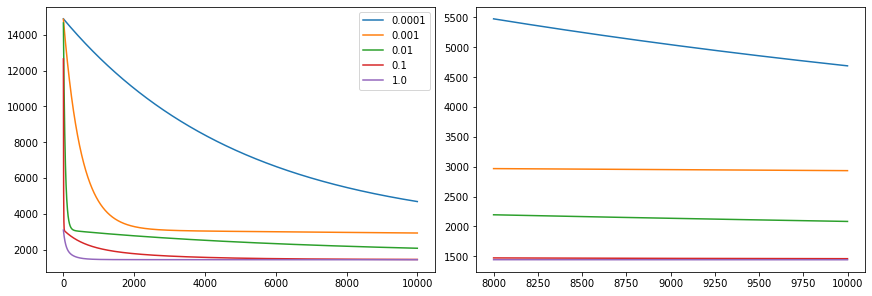

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

for learning_rate in learning_rates:
    cost_history = all_cost_histories[learning_rate]
    ax1.plot(cost_history, label=learning_rate)
    ax2.plot(8000 + np.arange(len(cost_history[8000:])), cost_history[8000:])

ax1.legend()
plt.show()

Remember, this is the cost on the validation set over the time the model was being trained. 0.1 looked to be the lowest cost, along with 1.0. However, training took a long time. Let's now train more optimally using matrix multiplication.

## Optimize Training With Matrix Multiplication

In [12]:
%%time
learning_rates = [1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1, 1.0]
all_cost_histories = {}
all_params = {}
lowest_val_cost = float('inf')
best_learning_rate = None

for learning_rate in learning_rates:
    lr_opt = LinearRegressionGD(alpha=learning_rate, max_iters=10000)
    lr_opt.train_optimized(X_train, y_train)
    curr_val_cost = lr_opt.compute_cost_optimized(X_val, y_val)
    
    if  curr_val_cost < lowest_val_cost:
        lowest_val_cost = curr_val_cost
        best_learning_rate = learning_rate
    
    # Get the parameters from the trained model that used the given learning rate.
    all_params[learning_rate] = lr_opt.get_parameters()
    
    # Tet the cost history when training the model using the given learning rate.
    all_cost_histories[learning_rate] = lr_opt.get_cost_history()

CPU times: total: 1.42 s
Wall time: 2.65 s


That was so much faster! Now we have a model. Let's compare this model with 

In [13]:
print(f'Best learning rate: {best_learning_rate}')
print(f'Total cost: {lowest_val_cost}')

Best learning rate: 0.1
Total cost: 1247.498399771716


In [14]:
 w,b = all_params[best_learning_rate]
print(f"(w,b) found by gradient descent using with learning rate = {best_learning_rate}: ({w},{b})\n")

(w,b) found by gradient descent using with learning rate = 0.1: ([  -8.0015293  -215.66974297  511.49071434  302.61074004  -81.9840265
 -155.67520644 -242.28331882  121.89996325  467.53916015  111.1361218 ],[153.32547323])



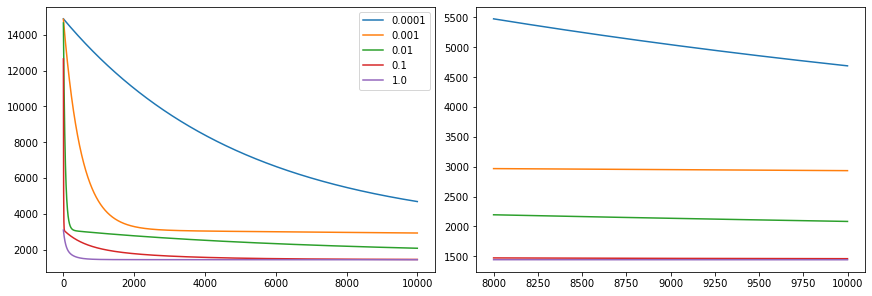

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

for learning_rate in learning_rates:
    cost_history = all_cost_histories[learning_rate]
    ax1.plot(cost_history, label=learning_rate)
    ax2.plot(8000 + np.arange(len(cost_history[8000:])), cost_history[8000:])

ax1.legend()
plt.show()

As expected, our results our identical, but using matrix multiplication was so much faster!

## Using Scikit-learn's SGDRegressor

Let's now compare our Gradient Descent Linear Regression model using Sci-kit Learn's SGDRegressor. We will use 0.1 as our learning rate since that was the best we found with our two previous models. Because SGDRegressor uses Stochastic Gradient Descent, where we used regular Gradient Descent, I don't expect results to be identical, but hopefully, they are similar.

In [16]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [17]:
sgdr = SGDRegressor(max_iter=10000, random_state=random_state, alpha=0.1, penalty=None, tol=1.0e-6)
sgdr.fit(X_train, y_train)

SGDRegressor(alpha=0.1, max_iter=10000, penalty=None, random_state=7, tol=1e-06)

In [18]:
b_norm = sgdr.intercept_
w_norm = sgdr.coef_
print(f"(w,b) found by Scikit-learn's SGDRegressor w: {w_norm}, b: {b_norm}")

(w,b) found by Scikit-learn's SGDRegressor w: [  -5.37951487 -207.81776546  505.07382526  298.97499368  -79.04159625
 -152.63077018 -240.4796409   123.4500191   459.75787107  114.88934167], b: [153.31277567]


In [19]:
from sklearn.metrics import mean_squared_error

In [20]:
y_val_pred = sgdr.predict(X_val)
# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_val, y_val_pred)
print("Cost on validation set:", mse/2)

Cost on validation set: 1240.5194652345365


As expected, the parameters and the validation cost are similar.

## Compare Test Data

Let's now compare the mean squared error of the test set using the three models.

In [21]:
# MSE of first model.
mse = lr.compute_mse(X_test, y_test)[0]
# MSE of optimized model.
mse_opt = lr.compute_mse_optimized(X_test, y_test)

# MSE of Sci-kit learn's SGDRegressor.
y_test_pred = sgdr.predict(X_test)
mse_sgdr = mean_squared_error(y_test, y_test_pred)

In [22]:
print(f'Mean squared error of Linear Regression model on test data: {mse}')
print(f'Mean squared error of optimal Linear Regression model on test data: {mse_opt}')
print(f"Mean squared error of Sci-kit Learn's SGD Regressor on test data: {mse_sgdr}")

Mean squared error of Linear Regression model on test data: 3226.24176565966
Mean squared error of optimal Linear Regression model on test data: 3226.2417656596604
Mean squared error of Sci-kit Learn's SGD Regressor on test data: 3113.6206390310494


The first two MSE's are the same, as expected. Scikit-learn's SGDRegressor has a similar, but better, MSE.

## Conclusion

In this notebook we have built a class that implements a linear regression architecture and build a linear regression model using gradient descent. The first model took a long time. So we optimized by using a model that uses Numpy's matrix multiplication which greatly increased the speed. We seen and expected that the model's results are the same. We then compared the model's results (weights and cost) with Scikit-learn's SGDRegressor. The weights and costs were similar with the SGDRegressor. We then used all 3 models to make predictions on the test data and compared their MSE's. We seen that all the results were similar.